In [6]:
import wandb
wandb.login()

True

In [7]:
from lightning.pytorch.loggers import WandbLogger
logger = WandbLogger(project="rl4co", name="luop-am")

In [8]:
from rl4co.envs import landuseOptEnv
import torch
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.models.nn.env_embeddings.context import LOPContext
from rl4co.models.nn.env_embeddings.dynamic import StaticEmbedding
from rl4co.models.nn.env_embeddings.init import lopInitEmbedding
from rl4co.utils import RL4COTrainer
from rl4co.utils.decoding import random_policy, rollout

In [9]:
batch_size = 1024
env = landuseOptEnv(generator_params=dict(num_loc=50))
emb_dim = 128
policy = AttentionModelPolicy(env_name=env.name, # this is actually not needed since we are initializing the embeddings!
                              embed_dim=emb_dim,
                              init_embedding=lopInitEmbedding(emb_dim),
                              context_embedding=LOPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)
# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       baseline='rollout',
                       policy=policy,
                       batch_size=512,
                       val_batch_size= 1024,
                       test_batch_size= 1024,
                       train_data_size=640_000, # really small size for demo
                       val_data_size=10_000,
                       test_data_size=10_000,
                       optimizer_kwargs={
                           "lr":1e-4,
                           "weight_decay": 1e-6,
                       },
                       lr_scheduler="MultiStepLR",
                       lr_scheduler_kwargs={
                            "milestones": [80, 95],
                            "gamma":0.1,
                       },
                       policy_kwargs={  # we can specify the decode types using the policy_kwargs
                           "train_decode_type": "sampling",
                           "val_decode_type": "greedy",
                           "test_decode_type": "greedy",
                       }
                       )


E:\temp\DRLtest\rl4co\rl4co\models\nn\attention.py:128: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  out = self.sdpa_fn(


Problem 1 | Cost: -0.632


D:\Anaconda3\envs\rl4co\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


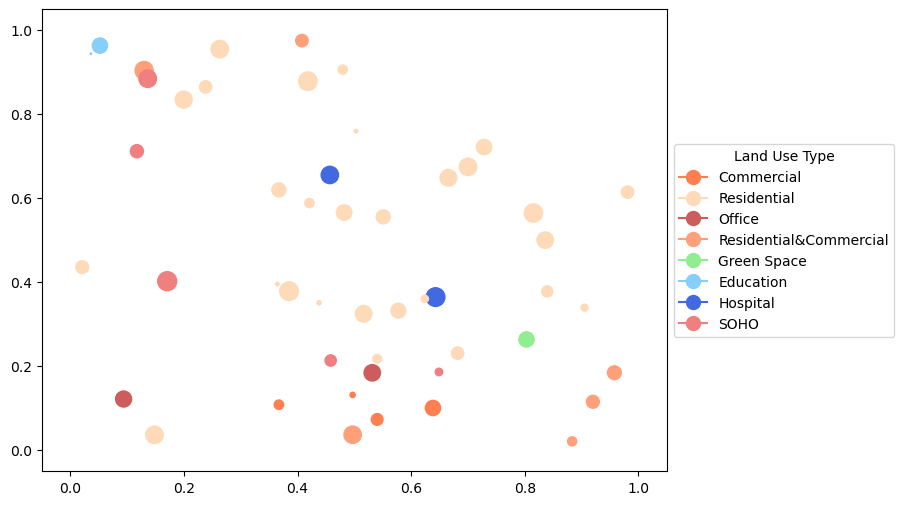

Problem 2 | Cost: -1.323


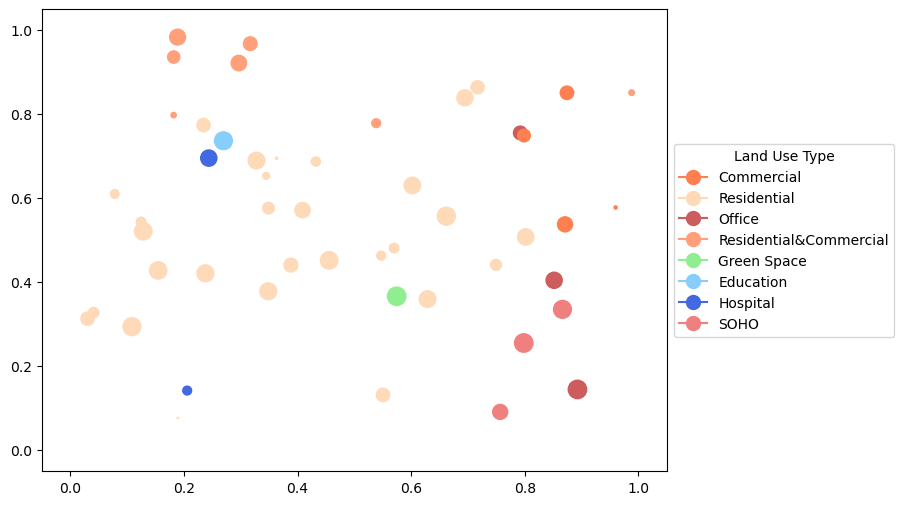

Problem 3 | Cost: -0.855


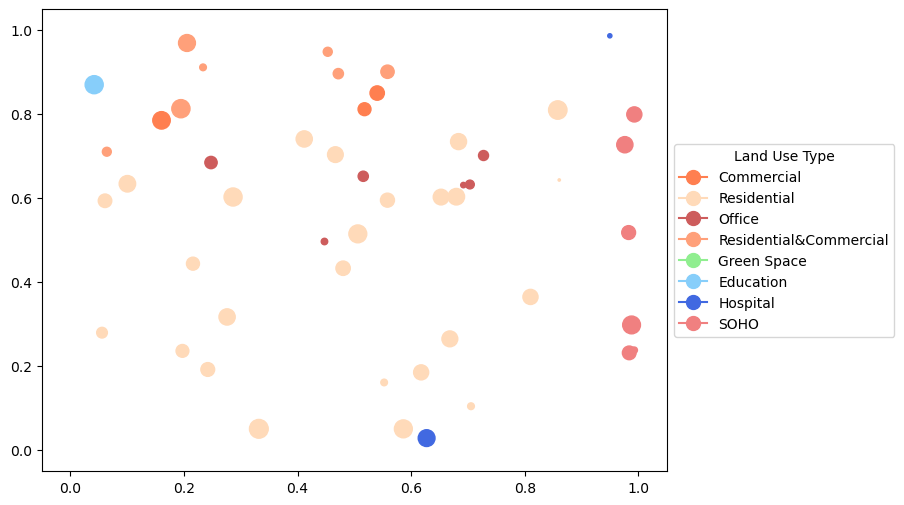

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)
# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

In [12]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model)

D:\Anaconda3\envs\rl4co\lib\site-packages\wandb\sdk\lib\ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory E:\temp\DRLtest\rl4co\tests\checkpoints exists and is not empty.
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ landuseOptEnv         │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  694 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  595 K │ train │
│ 3  │ policy.encoder.init_embedding          │ lopInitEmbedding      │    512 │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  594 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │ 99.3 K │ train │
│ 6  │ policy.decoder.context_embedding       │ LOPContext            │ 17.4 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ StaticEmbedding       │      0 │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ WarmupBaseline        │  694 K │ train │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  694 K │ train │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  694 K │ eval  │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

D:\Anaconda3\envs\rl4co\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Tour lengths: ['-1.24', '-1.56', '-1.37']


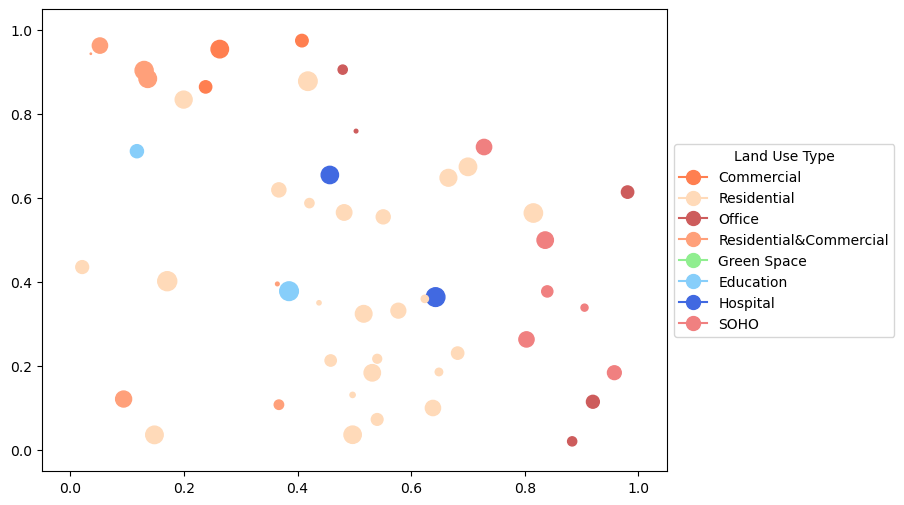

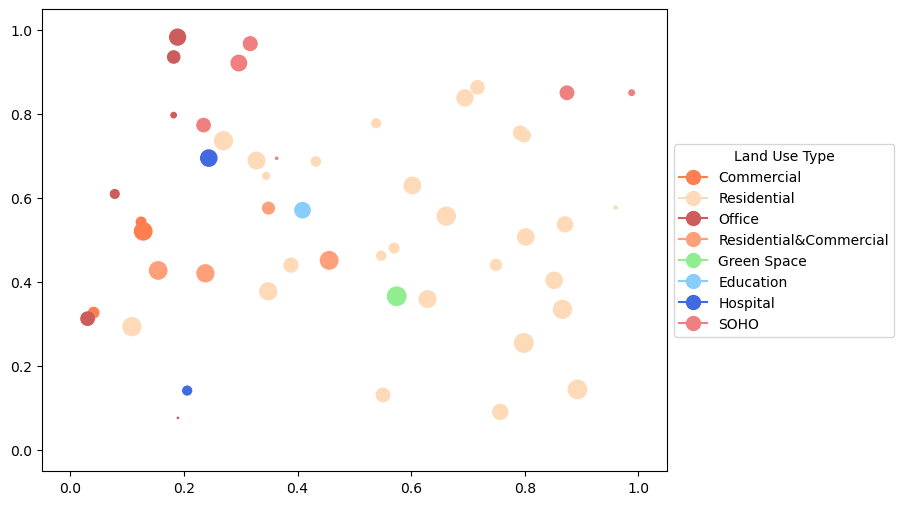

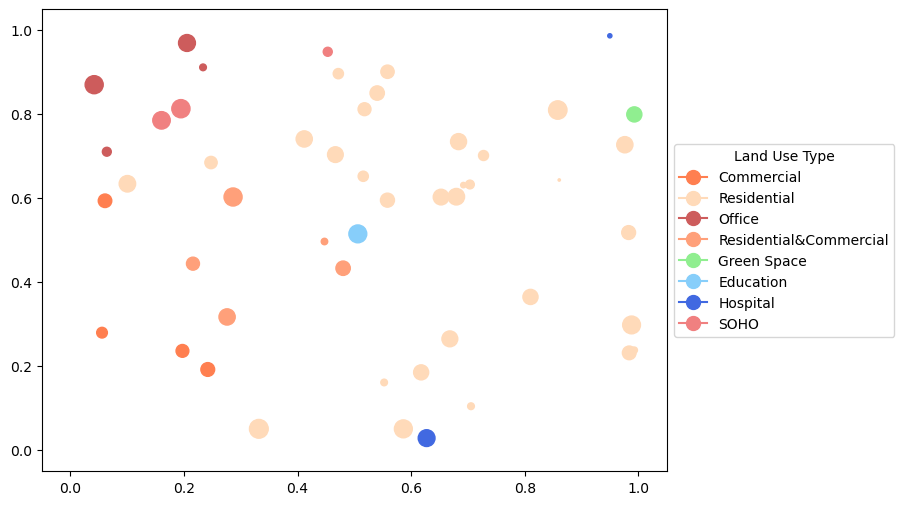

In [14]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out['actions'].cpu()):
    env.render(td, actions)